# CIT Assignment

Pedro Gomes

The purpose of the current task is to build a regression model capable of predicting a car's price based on several features. The dataset's description in the UCI webpage is the following:

*This data set consists of three types of entities:*
* *(a) the specification of an auto in terms of various characteristics*
* *(b) its assigned insurance risk rating*
* *(c) its normalized losses in use as compared to other cars.*

*The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price.   Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale.  Actuarians call this process "symboling".  A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.*

*The third factor is the relative average loss payment per insured vehicle year.  This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc...), and represents the average loss per car per year.*

*Note: Several of the attributes in the database could be used as a "class" attribute.*

***

Import the necessary packages:

In [1]:
import pandas as pd
import numpy as np

# Model saving
import pickle

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# SKLearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Feature engineering
from feature_engine.selection import DropFeatures
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
from feature_engine.imputation import CategoricalImputer, MeanMedianImputer

# Modelling
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

# Utils
from utils.utils import *

Read the data:

In [2]:
# Read the data, and give the headers the respective names
df = pd.read_csv(
    "data/imports-85.data",
    header=None,
    na_values="?",
    names=[
        "symboling",
        "normalized-losses",
        "make",
        "fuel-type",
        "aspiration",
        "num-of-doors",
        "body-style",
        "drive-wheels",
        "engine-location",
        "wheel-base",
        "length",
        "width",
        "height",
        "curb-weight",
        "engine-type",
        "num-of-cylinders",
        "engine-size",
        "fuel-system",
        "bore",
        "stroke",
        "compression-ratio",
        "horsepower",
        "peak-rpm",
        "city-mpg",
        "highway-mpg",
        "price",
    ],
)

Below, I include a brief description of each column in the dataset. This is based on my own research.

| Feature | Description |
| --- | --- |
|symboling|The risk factor associated to the car based on its price (a value of +3 indicates that the car is risky, a value of -3 means that it is safe).|
|normalized-losses|The relative average loss payment per insured vehicle year (in dollars). In other words, the average loss per car per year.|
|make|The brand that produces the car (Mitsubishi, Mercedes-Benz, etc.)|
|fuel-type|The car’s fuel type (gas or diesel).|
|aspiration|How the car's engine takes air (if "std" (standard), the air intake for the engine depends only on atmospheric pressure; otherwise, it has a forced induction ("turbo")).|
|num-of-doors|The number of doors the car has (two or four).|
|body-style|The car’s body style (hatchback, sedan, etc.).|
|drive-wheels|How the engine’s power is delivered to the wheels (if “4WD”, the engine’s power is delivered to all wheels at the same time; if “FWD” or “RWD”, the power is delivered to the front or back wheels, respectively).|
|engine-location|The location of the engine in the car (front or rear).|
|wheel-base|The distance between the front and back wheels (in inches).|
|length|The car’s length (in inches).|
|width|The car’s width (in inches).|
|height|The car’s height (in inches).|
|curb-weight|The car’s weight without any passengers or baggage (in pounds).|
|engine-type|The engine type (“OHC” for “Over Head Cam”, “DOHC” for “Double Over Head Cam”, etc.)|
|num-of-cylinders|The number of cylinders in the car’s engine.|
|engine-size|The volume of the cylinders inside an engine (in cubic inches).|
|fuel-system|The car’s fuel system (“MPFI” for “Multi Point Fuel Injection”, “IDI” for “Indirect Injection”, etc.).|
|bore|The diameter of each cylinder in the engine (in inches).|
|stroke|The distance travelled by the piston in the cylinder during one engine cycle (in inches).|
|compression-ratio|The ratio between the volume of the cylinder when the piston is at its minimum position vs when it is at its maximum position.|
|horsepower|A measure of the engine’s output. It is related to its power.|
|peak-rpm|The number of the engine’s revolutions per minute (RPM) at peak engine power.|
|city-mpg|The average distance that the car travels per gallon of fuel, measured on average city conditions (in miles).|
|highway-mpg|The average distance that the car travels per gallon of fuel, measured on average highway conditions (in miles).|


Check the data types of the columns and missing values:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    float64
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       203 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

The following columns contain missing values: 
* normalized-losses
* num-of-doors
* bore
* stroke
* horsepower
* peak-rpm
* price

I will be dropping the records which don't have the price values, as this is what we are interested in predicting.

In [4]:
df = df.dropna(subset=["price"])

Checking for duplicate records:

In [5]:
print(f"Number of duplicate records: {df.duplicated().sum()}")

Number of duplicate records: 0


However, a closer look (without considering the normalized losses and the price) shows that there are identical records:

In [6]:
df.loc[
    df.drop(columns=["normalized-losses", "price"]).duplicated(keep=False)
].sort_values(by=["make", "body-style"])

symboling  normalized-losses         make fuel-type aspiration  \
0            3                NaN  alfa-romero       gas        std   
1            3                NaN  alfa-romero       gas        std   
25           1              148.0        dodge       gas        std   
26           1              148.0        dodge       gas        std   
47           0              145.0       jaguar       gas        std   
48           0                NaN       jaguar       gas        std   
55           3              150.0        mazda       gas        std   
56           3              150.0        mazda       gas        std   
59           1              129.0        mazda       gas        std   
61           1              129.0        mazda       gas        std   
60           0              115.0        mazda       gas        std   
62           0              115.0        mazda       gas        std   
112          0              161.0       peugot    diesel      turbo   
116          0              161.0       peugot    diesel      turbo   
126          3                NaN      porsche       gas        std   
127          3                NaN      porsche       gas        std   

    num-of-doors   body-style drive-wheels engine-location  wheel-base  ...  \
0            two  convertible          rwd           front        88.6  ...   
1            two  convertible          rwd           front        88.6  ...   
25          four        sedan          fwd           front        93.7  ...   
26          four        sedan          fwd           front        93.7  ...   
47          four        sedan          rwd           front       113.0  ...   
48          four        sedan          rwd           front       113.0  ...   
55           two    hatchback          rwd           front        95.3  ...   
56           two    hatchback          rwd           front        95.3  ...   
59           two    hatchback          fwd           front        98.8  ...   
61           two    hatchback          fwd           front        98.8  ...   
60          four        sedan          fwd           front        98.8  ...   
62          four        sedan          fwd           front        98.8  ...   
112         four        sedan          rwd           front       107.9  ...   
116         four        sedan          rwd           front       107.9  ...   
126          two      hardtop          rwd            rear        89.5  ...   
127          two      hardtop          rwd            rear        89.5  ...   

     engine-size  fuel-system  bore  stroke compression-ratio horsepower  \
0            130         mpfi  3.47    2.68               9.0      111.0   
1            130         mpfi  3.47    2.68               9.0      111.0   
25            90         2bbl  2.97    3.23               9.4       68.0   
26            90         2bbl  2.97    3.23               9.4       68.0   
47           258         mpfi  3.63    4.17               8.1      176.0   
48           258         mpfi  3.63    4.17               8.1      176.0   
55            70         4bbl   NaN     NaN               9.4      101.0   
56            70         4bbl   NaN     NaN               9.4      101.0   
59           122         2bbl  3.39    3.39               8.6       84.0   
61           122         2bbl  3.39    3.39               8.6       84.0   
60           122         2bbl  3.39    3.39               8.6       84.0   
62           122         2bbl  3.39    3.39               8.6       84.0   
112          152          idi  3.70    3.52              21.0       95.0   
116          152          idi  3.70    3.52              21.0       95.0   
126          194         mpfi  3.74    2.90               9.5      207.0   
127          194         mpfi  3.74    2.90               9.5      207.0   

     peak-rpm city-mpg  highway-mpg    price  
0      5000.0       21           27  13495.0  
1      5000.0       21           27  16500.0  
25     5500.0      

This means that these records are identical apart from the normalized losses and their price; if the normalized losses is not used in the modelling process, this will confuse the model, as it will see two identical records with a different target. There are three approaches to this:

* Keep the data as it is.
* Keep only one of the records and delete the remaining.
* Aggregate these records. For example, by computing the mean of the Price and the normalized losses and then having just one record. 

I will consider the third approach, although it has the following caveat - this should be done in feature engineering, on the train and test sets separately, as to avoid data leakage. Here I will do it on the whole dataset, but I am aware the best way to proceed how I just described.

In [7]:
# Get the duplicate records
mask = df.drop(columns=["normalized-losses", "price"]).duplicated(keep=False)

df_duplicated = df.loc[mask]

# Strip the dataframe from these records
df = df.loc[~mask]

# Aggregate the duplicate records
df_duplicated = df_duplicated.groupby(
    df_duplicated.drop(columns=["normalized-losses", "price"]).columns.to_list(),
    as_index=False,
)[["normalized-losses", "price"]].mean()

# Append the aggregated duplicate records to the dataframe
df = df.append(df_duplicated, ignore_index=True).reset_index(drop=True)

C:\Users\GOP1LIS\AppData\Local\Temp\ipykernel_15568\2737684990.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_duplicated, ignore_index=True).reset_index(drop=True)


Get summary statistics for the numerical columns:

In [8]:
df.describe()

symboling  normalized-losses  wheel-base      length       width  \
count  192.000000         158.000000  192.000000  192.000000  192.000000   
mean     0.807292         121.234177   98.840104  174.164062   65.877083   
std      1.240397          35.762516    5.981805   12.352307    2.114472   
min     -2.000000          65.000000   86.600000  141.100000   60.300000   
25%      0.000000          94.000000   94.500000  166.300000   64.075000   
50%      1.000000         113.000000   97.000000  173.200000   65.500000   
75%      2.000000         149.500000  102.400000  183.500000   66.675000   
max      3.000000         256.000000  120.900000  208.100000   72.000000   

           height  curb-weight  engine-size        bore      stroke  \
count  192.000000   192.000000   192.000000  190.000000  190.000000   
mean    53.844792  2549.598958   126.531250    3.325579    3.254368   
std      2.411290   513.038164    40.609738    0.270386    0.313511   
min     47.800000  1488.000000    61.000000    2.540000    2.070000   
25%     52.000000  2145.000000    98.000000    3.150000    3.110000   
50%     54.100000  2417.000000   115.000000    3.310000    3.290000   
75%     55.625000  2928.250000   141.000000    3.580000    3.410000   
max     59.800000  4066.000000   326.000000    3.940000    4.170000   

       compression-ratio  horsepower     peak-rpm    city-mpg  highway-mpg  \
count         192.000000  190.000000   190.000000  192.000000     192.0000   
mean           10.156354  102.889474  5113.157895   25.328125      30.8125   
std             4.014255   37.163921   472.033232    6.424075       6.8351   
min             7.000000   48.000000  4150.000000   13.000000      16.0000   
25%             8.500000   70.000000  4800.000000   19.000000      25.0000   
50%             9.000000   95.000000  5200.000000   24.000000      30.0000   
75%             9.400000  116.000000  5500.000000   30.000000      34.5000   
max            23.000000  262.000000  6600.000000   49.000000      54.0000   

              price  
count    192.000000  
mean   13052.093750  
std     7822.932104  
min     5118.000000  
25%     7765.750000  
50%     9992.000000  
75%    16447.500000  
max    45400.000000

***

## Basic (univariate) exploratory data analysis

In this section, I will analyze each feature individually, as well as the target column. The purpose is to understand the distribution of each feature and other properties (such as outliers).

Symboling

From the plot below, it can be seen that:
* More than 30% of the automobiles have "0" as the insurance risk rating, and around 13% are considered not risky (these have a symboling value of -1 and -2).
* In Feature Engineering, one possible feature to create is a flag indicating if the car is risky or not. This flag could take the value 0 if symboling is equal or less than 0, and 1 otherwise.

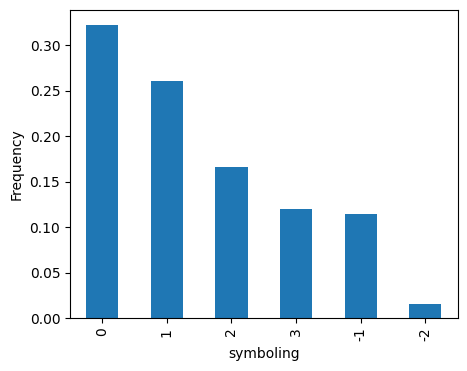

In [9]:
plot_categorical_feature(data_frame=df, column="symboling")

Normalized losses

* Most of the cars have normalized losses below 150$ (the median of this variable is 113$, so 50% of the data is below this value). The distribution of this variable is right skewed, as can be seen from the histogram on the left and on the QQ plot on the right.
* There is one outlier, with a normalized loss above 250€.

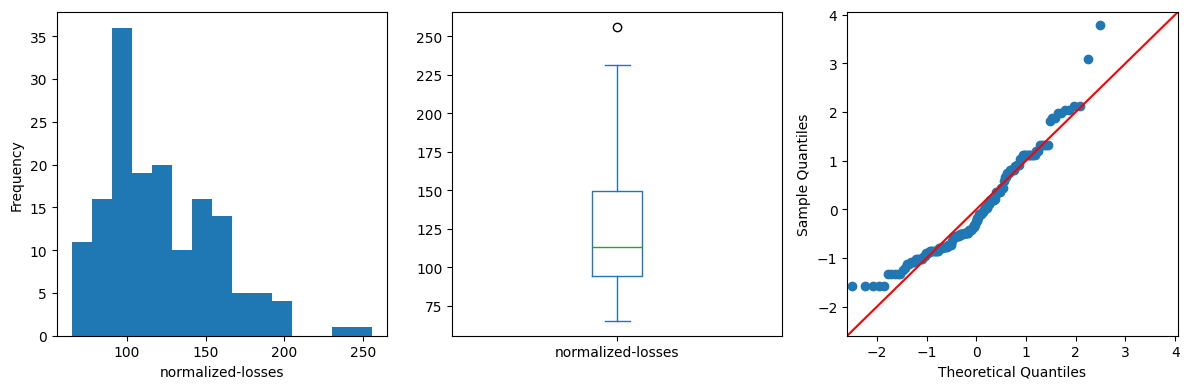

In [10]:
plot_numerical_feature(data_frame=df, column="normalized-losses", plot_qq=True, figsize=(12,4))

An analysis of the the record concerning the outlier shows that it has a symboling of +3, therefore making it a car with high risk. From this analysis, I can not conclude that this outlier is a wrong value or not, so I will keep it. However, in a real world problem, a more detailed analysis of this should be pursued.

In [11]:
get_outlier_records(data_frame=df, column="normalized-losses")

symboling  normalized-losses        make fuel-type aspiration  \
170          3              256.0  volkswagen       gas        std   

    num-of-doors body-style drive-wheels engine-location  wheel-base  ...  \
170          two  hatchback          fwd           front        94.5  ...   

     engine-size  fuel-system  bore  stroke compression-ratio horsepower  \
170          109         mpfi  3.19     3.4               8.5       90.0   

     peak-rpm city-mpg  highway-mpg   price  
170    5500.0       24           29  9980.0  

[1 rows x 26 columns]

Make

* Most of the cars are of the Toyota brand, followed by Nissan and Mazda.
* Some car brands - such as Mercury, Renault and Isuzu - have a very small frequency in the dataset (below 2.5%, represented by the horizontal dashed line). In some problems (mostly classification ones) this can be an issue, as "unfrequent" categories can lead the algorithm to overfit the training data easily.

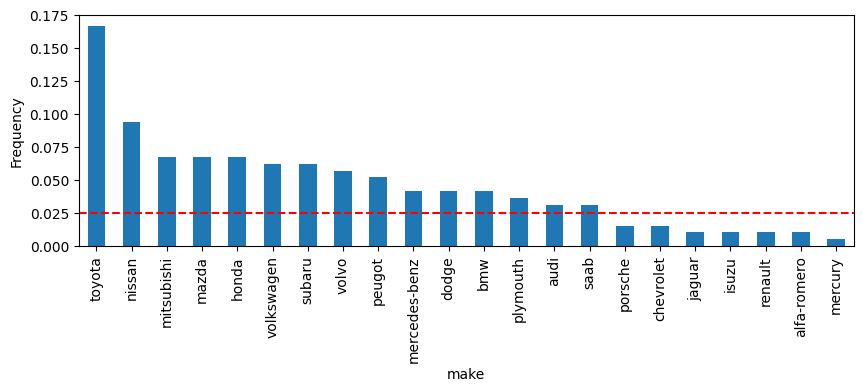

In [12]:
plot_categorical_feature(data_frame=df, column="make", figsize=(10, 3), plot_h_line=True, h_threshold=0.025)

Fuel type

* The vast majority of the cars are gas cars.

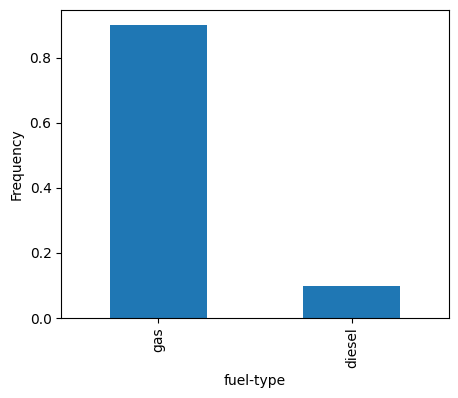

In [13]:
plot_categorical_feature(data_frame=df, column="fuel-type")

Aspiration

* Most of the cars used STD (standard) aspiration.

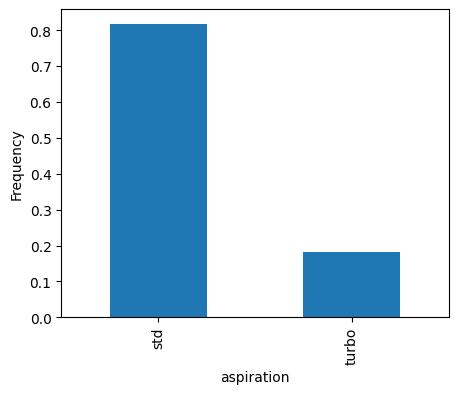

In [14]:
plot_categorical_feature(data_frame=df, column="aspiration")

Number of doors

* Most of the cars have 4 doors.

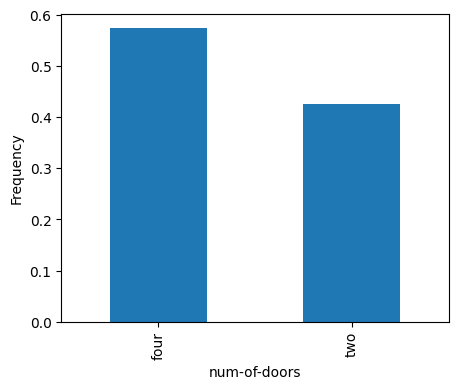

In [15]:
plot_categorical_feature(data_frame=df, column="num-of-doors")

For columns that contain numbers but these numbers are written in text, I will be replacing the text description of the number by the number itself:

In [16]:
df = df.replace({"num-of-doors": {"two": 2, "four": 4}})

Ideally, this should be done using a proper transformer class that maps each possible category to the respective number, within the Feature Engineering pipeline, instead of hard-coding it as I did above; if new records with a different value for this variable are introduced (for example, a car that has three doors), this mapping would ignore such cases, which is not desired in a production environment.

Body style

* Most cars are sedans, followed by hatchbacks.
* Hardtop and convertibles have a small presence in the data (they are present in less than 5% of the observations, represented by the dashed red curve).

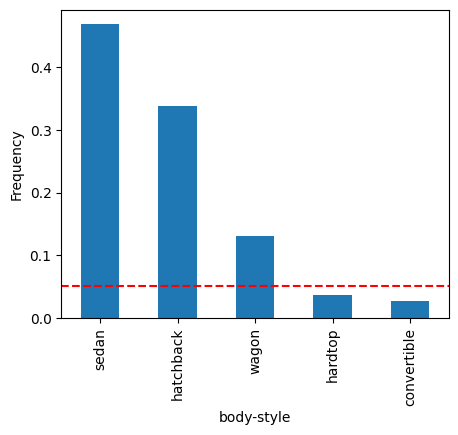

In [17]:
plot_categorical_feature(data_frame=df, column="body-style", plot_h_line=True)

Drive wheels

* Almost 60% of the cars have the engine power delivered to the front wheels (FWD).
* Less than 5% have the power delivered to all wheels (4WD).

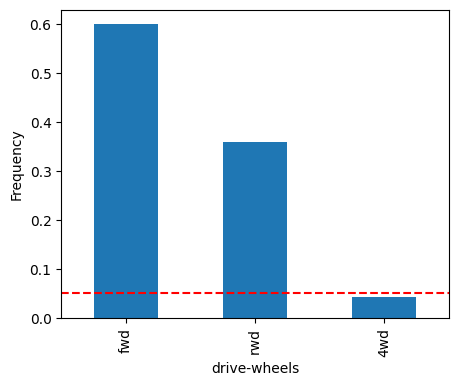

In [18]:
plot_categorical_feature(data_frame=df, column="drive-wheels", plot_h_line=True)

Engine location

* Practically 100% of the cars have the engine in the front. This is a quasi-constant feature.

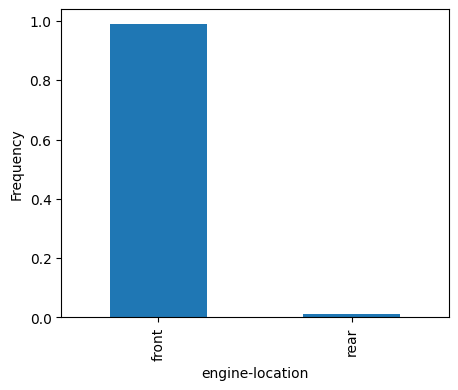

In [19]:
plot_categorical_feature(data_frame=df, column="engine-location")

A closer look reveals that all the cars that have the engine in the rear are Porsche vehicles:

In [20]:
df.loc[df["engine-location"] == "rear"][["make", "engine-location"]]

make engine-location
109  porsche            rear
191  porsche            rear

Wheel base

* This variable has a right-skewed distribution, as can be seen from the histogram on the left and the QQ plot on the right.
* Most of the cars have a wheel base below 105 in.
* There are 3 outliers for this variable. Comparing these values to those of other cars, they don't look abnormal, so I will keep these records.

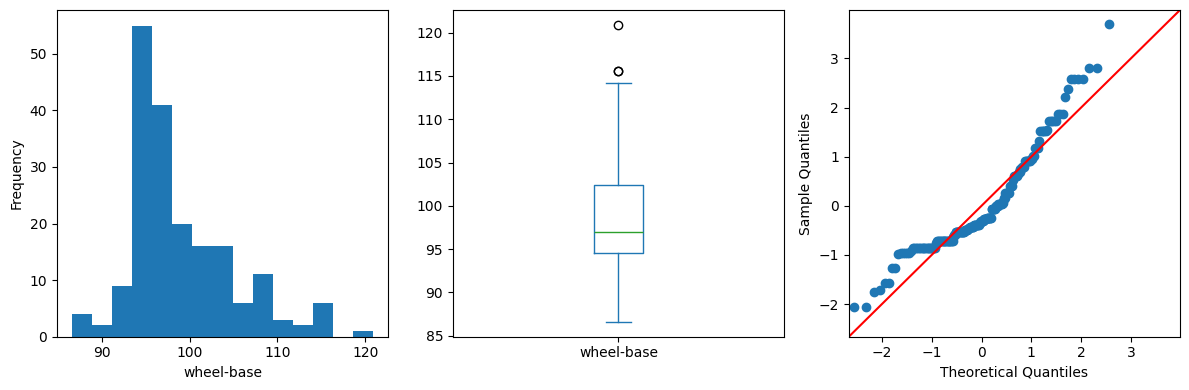

In [21]:
plot_numerical_feature(data_frame=df, column="wheel-base", plot_qq=True, figsize=(12,4))

The outliers concern Mercedes-Benz sedans, which are typically longer cars (perhaps comparable to wagons):

In [22]:
get_outlier_records(data_frame=df, column="wheel-base")[["make", "aspiration", "num-of-doors", "body-style", "length", "wheel-base"]]

make aspiration  num-of-doors body-style  length  wheel-base
55  mercedes-benz      turbo           4.0      sedan   202.6       115.6
56  mercedes-benz        std           4.0      sedan   202.6       115.6
58  mercedes-benz        std           4.0      sedan   208.1       120.9

Length

* This feature's distribution if close to a normal distribution. 
* Most cars have a length between 155 and 195.

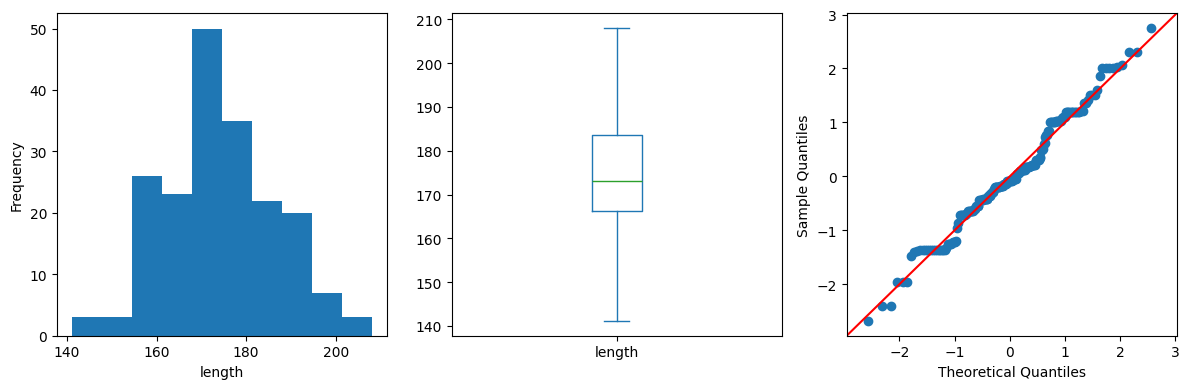

In [23]:
plot_numerical_feature(data_frame=df, column="length", bins=10, plot_qq=True, figsize=(12,4))

Width

* Most cars have widths between 63 and 68 in.
* There are multiple outliers for this variable, as can be seen from the Boxplot diagram.

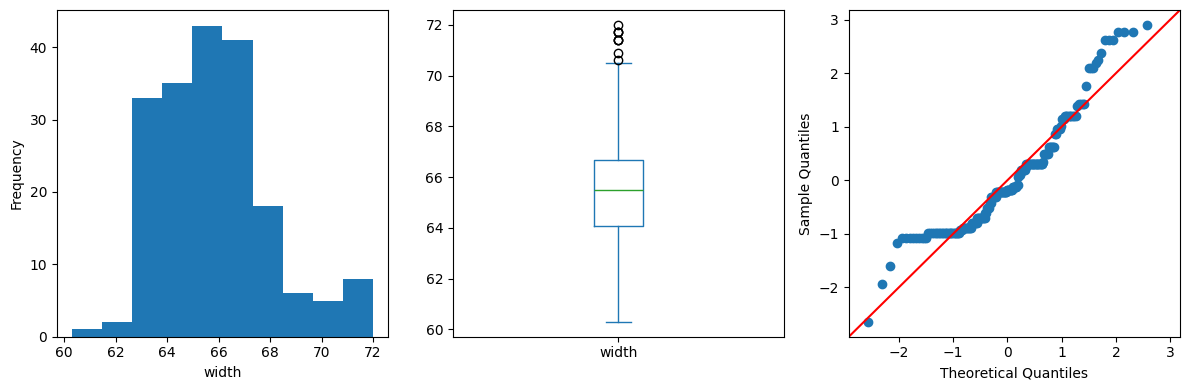

In [24]:
plot_numerical_feature(data_frame=df, column="width", bins=10, plot_qq=True, figsize=(12,4))

Checking the outlier values shows that:
* The other outliers concern longer vehicles (sedans and wagons, mostly), and the values seem to be within the reasonable range.

In [25]:
get_outlier_records(data_frame=df, column="width")[["make", "body-style", "length", "width"]]

make body-style  length  width
4            audi      sedan   192.7   71.4
5            audi      wagon   192.7   71.4
6            audi      sedan   192.7   71.4
14            bmw      sedan   197.0   70.9
40         jaguar      sedan   191.7   70.6
55  mercedes-benz      sedan   202.6   71.7
56  mercedes-benz      sedan   202.6   71.7
58  mercedes-benz      sedan   208.1   71.7
59  mercedes-benz    hardtop   199.2   72.0

Height

* This variable's distribution is close to a normal distribution, with a mean value around 54 in.

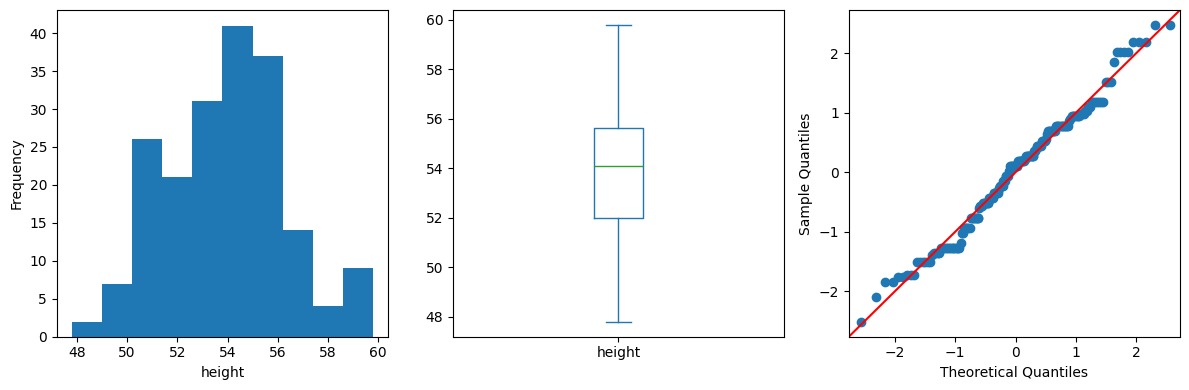

In [26]:
plot_numerical_feature(data_frame=df, column="height" , bins=10, plot_qq=True, figsize=(12,4))

Curb weight

* Most cars have a curb weight between 1750 and 3250 pounds.

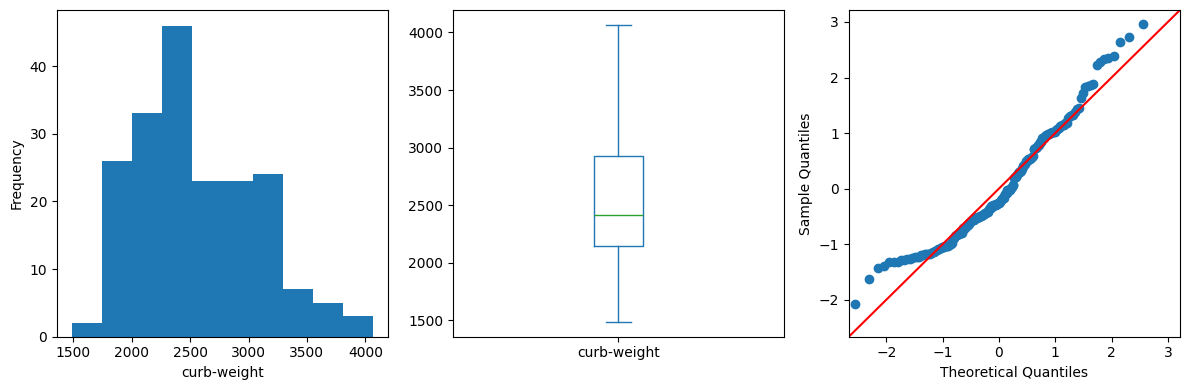

In [27]:
plot_numerical_feature(data_frame=df, column="curb-weight", bins=10, plot_qq=True, figsize=(12,4))

Engine type

* For the vast majority of cars, the engine type is OHC.
* The other engine categories have a much smaller frequency in the data, especially "rotor".

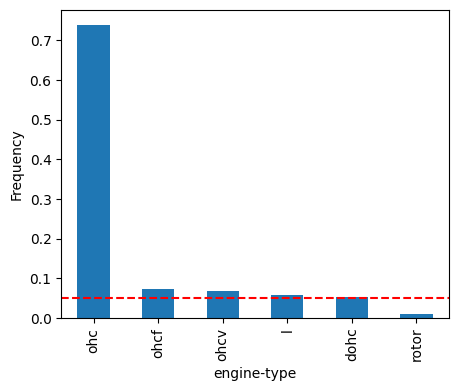

In [28]:
plot_categorical_feature(data_frame=df, column="engine-type", plot_h_line=True)

Number of cylinders

* The vast majority of cars have 4 cylinders in their engine.

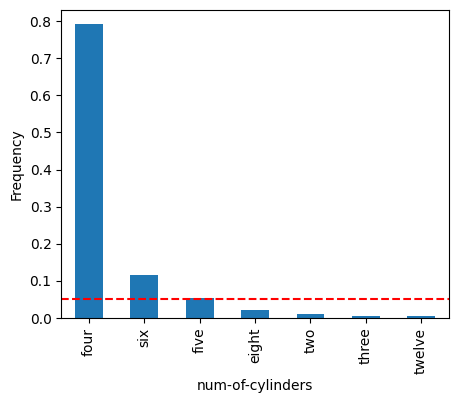

In [29]:
plot_categorical_feature(data_frame=df, column="num-of-cylinders", plot_h_line=True)

As for the number of doors feature, I will replace the description in text with the actual numbers:

In [30]:
df = df.replace(
    {
        "num-of-cylinders": {
            "two": 2,
            "three": 3,
            "four": 4,
            "five": 5,
            "six": 6,
            "eight": 8,
            "twelve": 12,
        }
    }
)

Engine size

* Most cars have engine sizes below 150 cubic inches (the median of this variable is at 115 cubic inches).
* There are some outliers in this variable (probably concerning more expensive cars, which have bigger engines).

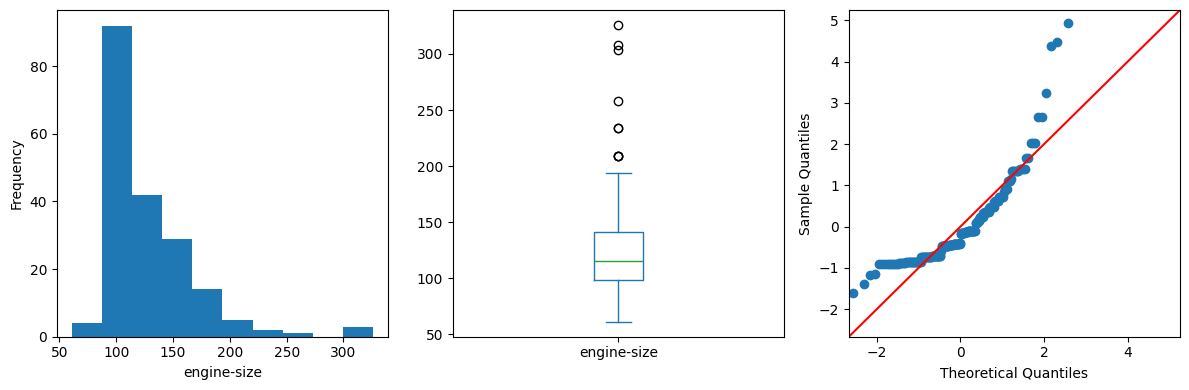

In [31]:
plot_numerical_feature(data_frame=df, column="engine-size", bins=10, plot_qq=True, figsize=(12,4))

Checking the outlier cases, it is confirmed that these concern cars with bigger cylinders (and therefore, the values are correct):

In [32]:
get_outlier_records(data_frame=df, column="engine-size")[["make", "engine-size", "num-of-cylinders"]]

make  engine-size  num-of-cylinders
12             bmw          209                 6
13             bmw          209                 6
14             bmw          209                 6
40          jaguar          326                12
56   mercedes-benz          234                 8
57   mercedes-benz          234                 8
58   mercedes-benz          308                 8
59   mercedes-benz          304                 8
185         jaguar          258                 6

Fuel system

* The dominant fuel systems are MPFI and 2BBL.
* The SPDI, 4BBL, MFI and SPFI types are quite rare, having a frequency less than 5%.

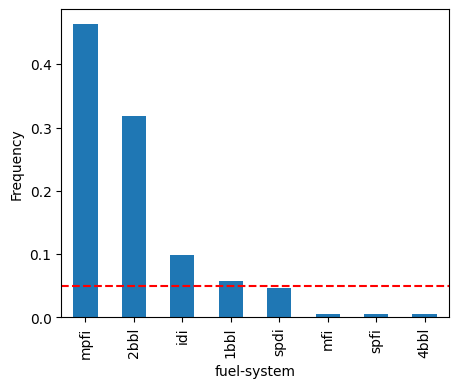

In [33]:
plot_categorical_feature(data_frame=df, column="fuel-system", plot_h_line=True)

Bore

* Most vehicles have bores between 3 and 3.6 in.

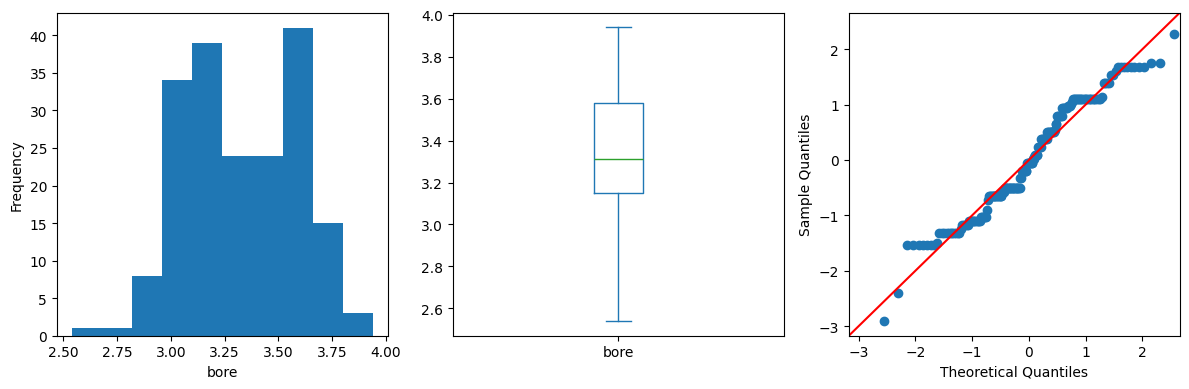

In [34]:
plot_numerical_feature(data_frame=df, column="bore", bins=10, plot_qq=True, figsize=(12,4))

Stroke
* Most cars have stroke values between 2.75 and 3.5 in.
* There are some outliers to this variable.

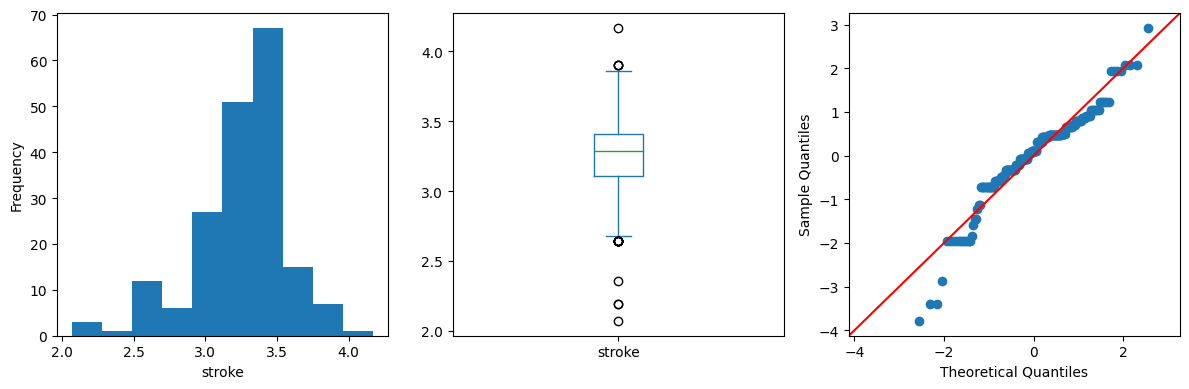

In [35]:
plot_numerical_feature(data_frame=df, column="stroke", bins=10, plot_qq=True, figsize=(12,4))

Compression ratio

* Compression ratio exhibits two very different ranges of values.

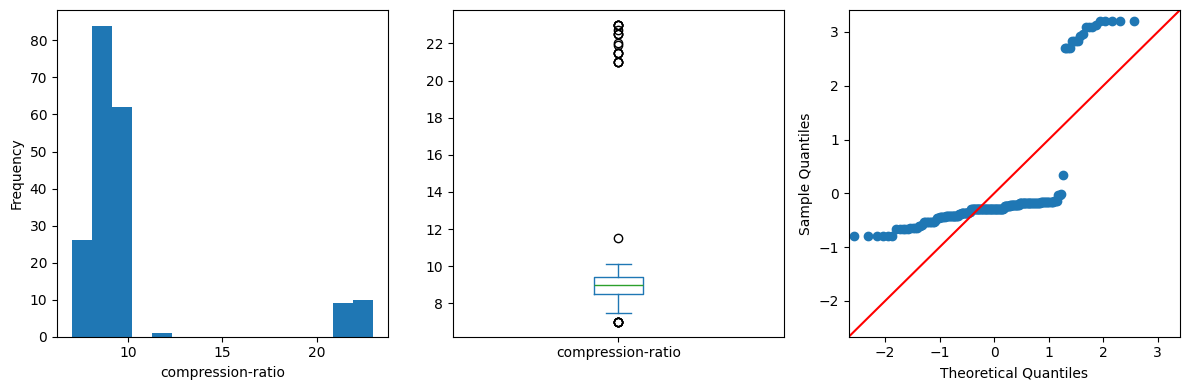

In [36]:
plot_numerical_feature(data_frame=df, column="compression-ratio", plot_qq=True, figsize=(12,4))

This difference in compression ratios is related to the different fuel types - the lower values concern gas vehicles, whereas the upper ones concern diesel vehicles (the higher compression ratio of diesel engines makes them more efficient than gas engines).

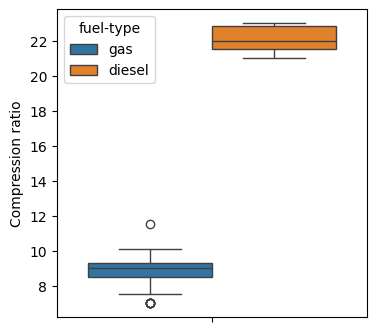

In [37]:
plt.figure(figsize=(4, 4))

sns.boxplot(y="compression-ratio", data=df, hue="fuel-type")

plt.ylabel("Compression ratio")
plt.show()

Horsepower

* Most cars have a horsepower below 150 (the median is at 95).
* There are some outliers to this feature.

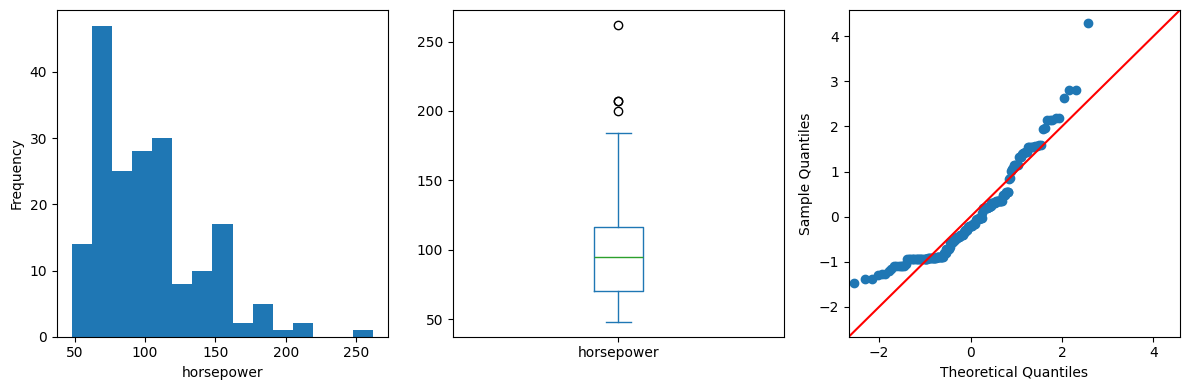

In [38]:
plot_numerical_feature(data_frame=df, column="horsepower", plot_qq=True, figsize=(12,4))

These outliers seem to match the cars with more powerful engines:

In [39]:
get_outlier_records(data_frame=df, column="horsepower")[["make", "engine-size", "num-of-cylinders", "horsepower"]]

make  engine-size  num-of-cylinders  horsepower
40    jaguar          326                12       262.0
90    nissan          181                 6       200.0
109  porsche          194                 6       207.0
191  porsche          194                 6       207.0

Peak-RPM

* Most engines have between 4500 and 5500 RPM at peak power.
* There are two outliers at 6600 RPM, concerning Toyota vehicles; nevertheless, these are still normal values for this category.

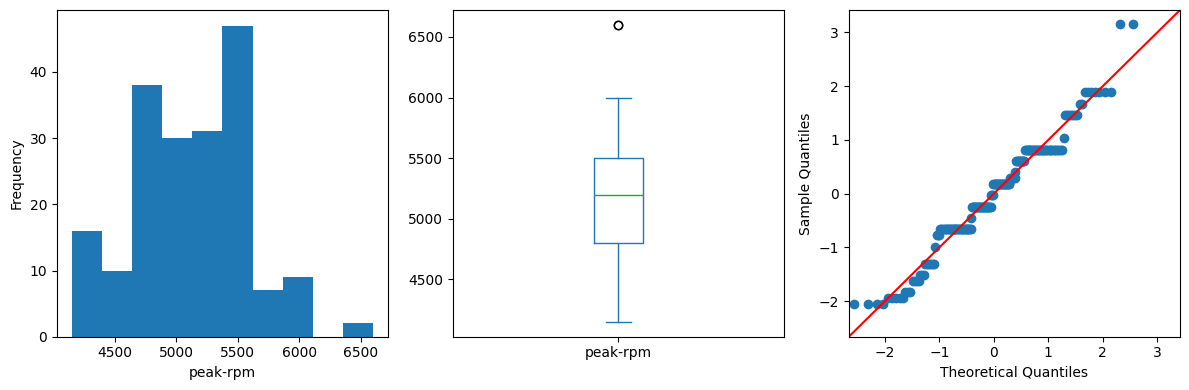

In [40]:
plot_numerical_feature(data_frame=df, column="peak-rpm", plot_qq=True, figsize=(12,4), bins=10)

In [41]:
get_outlier_records(data_frame=df, column="peak-rpm")[
    [
        "make",
        "body-style",
        "engine-size",
        "horsepower",
        "num-of-cylinders",
        "price",
        "fuel-type",
    ]
]

make body-style  engine-size  horsepower  num-of-cylinders   price  \
145  toyota      sedan           98       112.0                 4  9298.0   
146  toyota  hatchback           98       112.0                 4  9538.0   

    fuel-type  
145       gas  
146       gas

City-MPG

* Most cars travel between 15 and 35 miles with 1 gallon of fuel in city conditions.
* The two outliers still assume reasonable values, so they will be kept as they are.

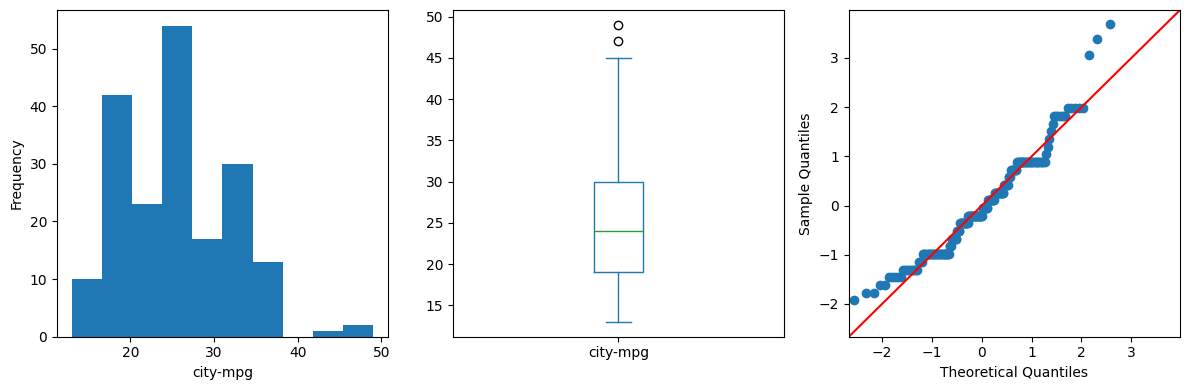

In [42]:
plot_numerical_feature(data_frame=df, column="city-mpg", bins=10, plot_qq=True, figsize=(12,4))

Highway-MPG

* Most cars travel between 20 and 40 miles with 1 gallon of fuel in highway conditions.
* The outliers still assume reasonable values, so they will be kept as they are.

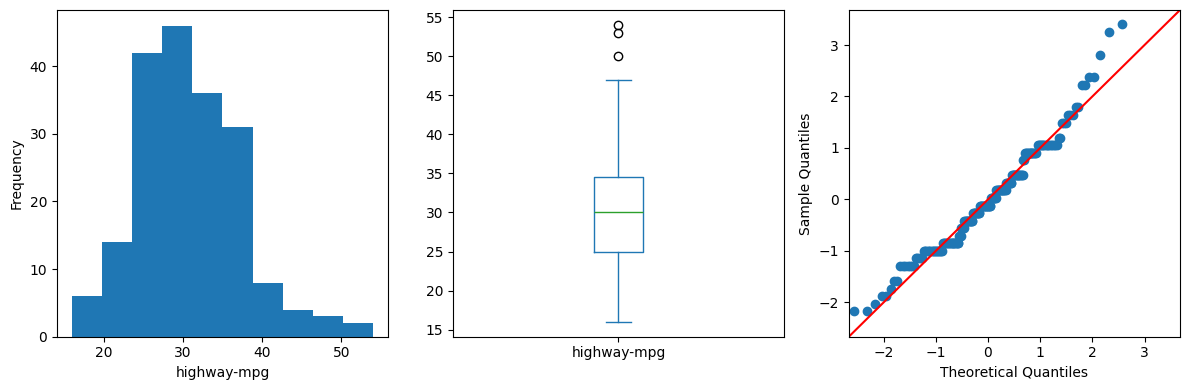

In [43]:
plot_numerical_feature(data_frame=df, column="highway-mpg", bins=10, plot_qq=True, figsize=(12,4))

Price

* The target variable shows a right-skewed distribution, wigh higher prices being less common.
* It ranges from 5118$ to 45 400$.

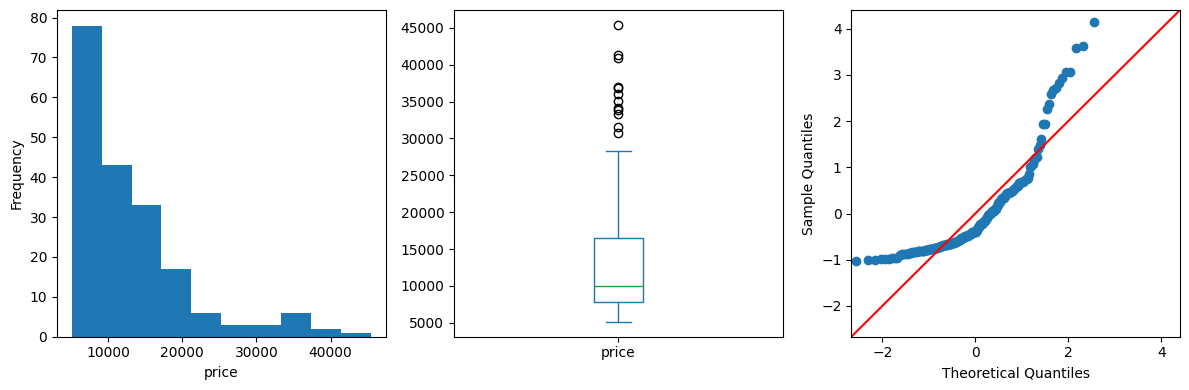

In [44]:
plot_numerical_feature(data_frame=df, column="price", plot_qq=True, figsize=(12,4), bins=10)

***
## Multivariate exploratory data analysis
### Relationships between features

In this section, I will analyze the relations between features, and the features and the target variable.

A check of the symboling by car make shows that:
* Alfa-Romero, Audi, Mitsubishi, Saab, and Volkswagen cars are high risk (the majority of the vehicles in these categories have positive symboling).
* All Porsche cars have very high risk.
* All Volvo cars are considered safe (they have a risk smaller than 0).

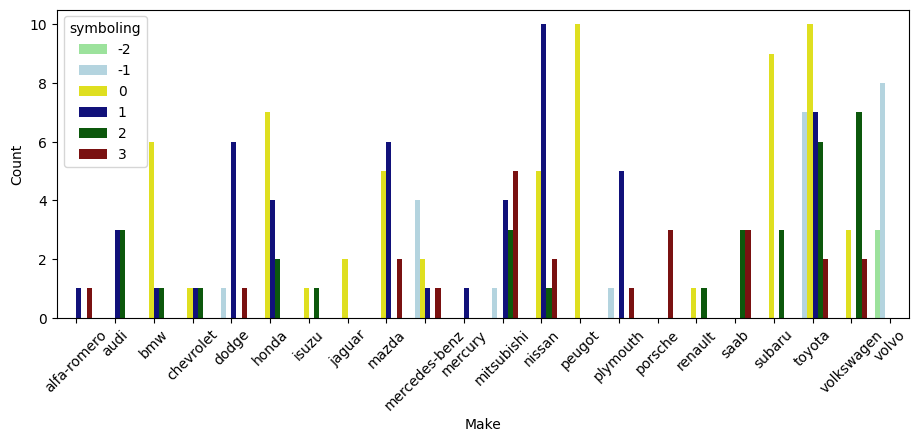

In [45]:
figure(figsize=(11, 4))

sns.countplot(
    data=df,
    x="make",
    hue="symboling",
    palette={
        -3: "lightred",
        -2: "lightgreen",
        -1: "lightblue",
        0: "yellow",
        1: "darkblue",
        2: "darkgreen",
        3: "darkred",
    },
)

plt.xlabel("Make")
plt.ylabel("Count")

plt.xticks(rotation=45)
plt.show()

Analysis of the mean normalized loss per make shows that:

* BMW, Porsche, Audi and Peugeot vehicles are the ones that represent the biggest loss in insurance terms.
* Data regarding the loss per car per year is not available for Alfa-Romero, Isuzu, Mercury and Renault.

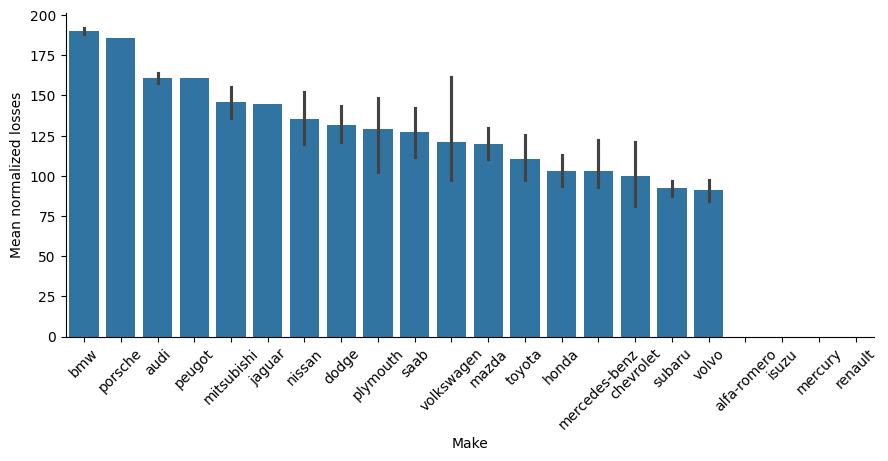

In [46]:
sns.catplot(
    data=df,
    x="make",
    y="normalized-losses",
    kind="bar",
    height=4,
    aspect=2.25,
    order=df.groupby("make")["normalized-losses"]
    .mean()
    .sort_values(ascending=False)
    .index,
)

plt.ylabel("Mean normalized losses")
plt.xlabel("Make")
plt.xticks(rotation=45)

plt.show()

* The cars with greater horsepower, on average, are Porsche (hardtops and convertibles) and Jaguar sedans.
* The cars with less horsepower are Chevrolet (hatchbacks and sedans).

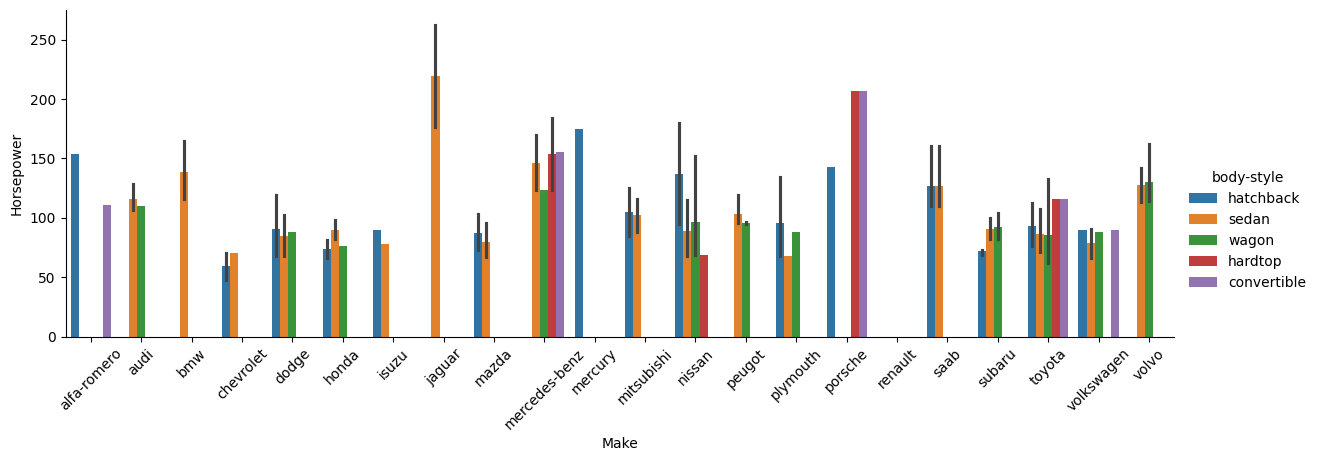

In [47]:
sns.catplot(
    data=df, x="make", y="horsepower", hue="body-style", kind="bar", height=4, aspect=3
)

plt.xlabel("Make")
plt.ylabel("Horsepower")
plt.xticks(rotation=45)
plt.show()

### Relationships between categorical features and the target

This section consists in the analysis of the relationship between categorical variables and the target column.

* For gas and diesel cars, there is some overlap in price values; it is not clear if there is a significant price difference between both.
* To assess if there is a significant difference in price between the two groups, hypothesis testing (namely, a T-test) could be conducted; however, t-tests assume that the data is normally distributed, which is not the case for the Price (as seen above, it has a right-skewed distribution). The target column would have to be transformed for this.

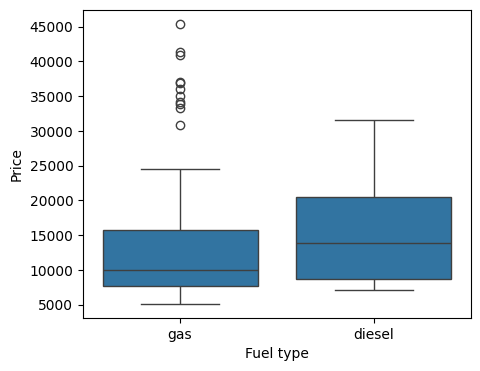

In [48]:
plt.figure(figsize=(5, 4))

sns.boxplot(x="fuel-type", y="price", data=df)
plt.xlabel("Fuel type")
plt.ylabel("Price")
plt.show()

* The same happens for engine aspiration type.

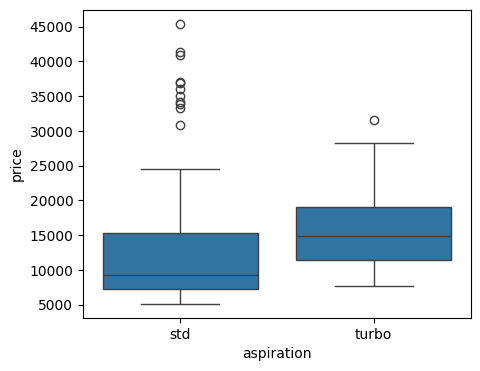

In [49]:
plt.figure(figsize=(5, 4))

sns.boxplot(x="aspiration", y="price", data=df)
plt.show()

* Jaguar, Porsche, Mercedes-Benz and BMW are the priciest cars.
* The "make" feature might be useful in predicting the price, given the price distributions between each brand.

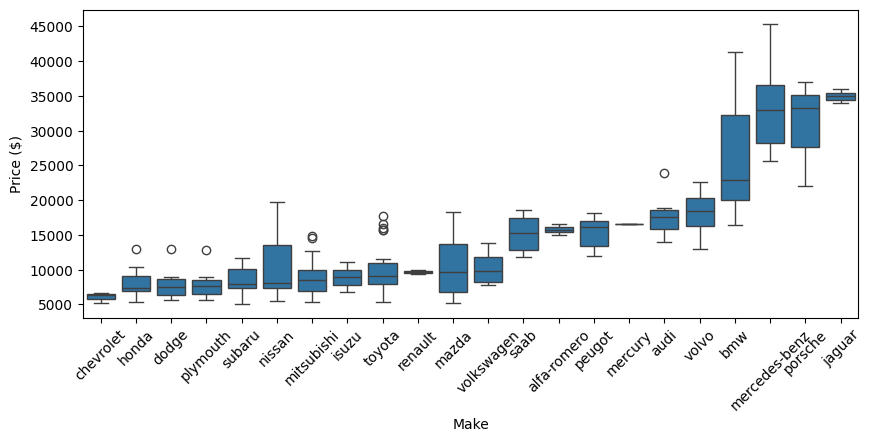

In [50]:
plt.figure(figsize=(10, 4))

sns.boxplot(
    x="make",
    y="price",
    data=df,
    order=df.groupby("make")["price"].median().sort_values().index,
)

plt.xlabel("Make")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.show()

* The different body styles have a significant overlap when it comes to the price. Nevertheless, convertible vehicles seem to be the most expensive.
* Differences in price between the groups could also be assessed with hypothesis testing (namely ANOVA).


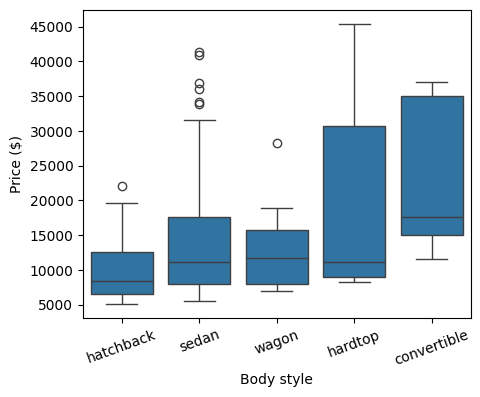

In [51]:
plt.figure(figsize=(5, 4))

sns.boxplot(x="body-style", y="price", data=df)

plt.xlabel("Body style")
plt.ylabel("Price ($)")
plt.xticks(rotation=20)
plt.show()

* Cars that have the engine's power delivered to the rear wheels are more expensive.

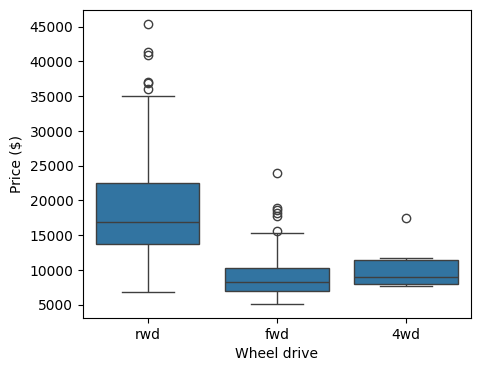

In [52]:
plt.figure(figsize=(5, 4))

sns.boxplot(x="drive-wheels", y="price", data=df)

plt.xlabel("Wheel drive")
plt.ylabel("Price ($)")
plt.show()

* Cars with a higher number of cylinders are more expensive; this makes sense, as more cylinders means more power delivered, and engine power is correlated with price (this is seen in the next section).

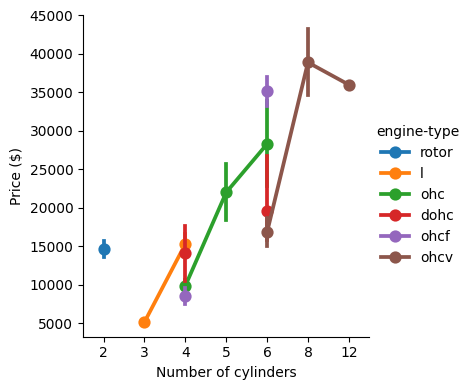

In [53]:
sns.catplot(
    x="num-of-cylinders", y="price", data=df, kind="point", height=4, hue="engine-type"
)

plt.xlabel("Number of cylinders")
plt.ylabel("Price ($)")
plt.show()

* Cars with the engine on the rear have higher prices than those that have the engine in the front:

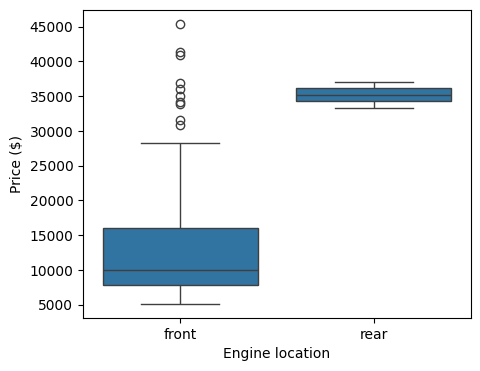

In [54]:
plt.figure(figsize=(5, 4))

sns.boxplot(x="engine-location", y="price", data=df)
plt.xlabel("Engine location")
plt.ylabel("Price ($)")
plt.show()

Such vehicles are Porsches, which explains this difference:

In [55]:
df.loc[df["engine-location"] == "rear"][["make", "fuel-type", "body-style", "engine-location"]]

make fuel-type   body-style engine-location
109  porsche       gas  convertible            rear
191  porsche       gas      hardtop            rear

* The different Fuel systems have some price differences between them.
* MPFI is the one with the highest price.
* It would be interesting to do a further analysis of the make *vs* the fuel system and understand if there is a relationship.

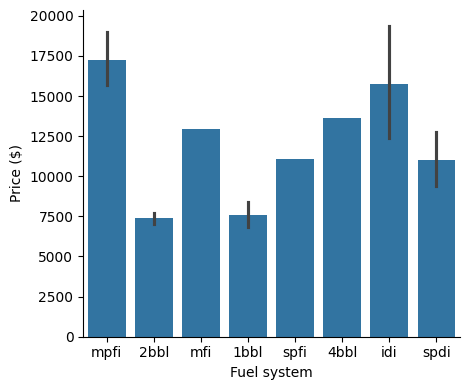

In [56]:
sns.catplot(x="fuel-system", y="price", data=df, kind="bar", height=4, aspect=1.2)
plt.xlabel("Fuel system")
plt.ylabel("Price ($)")

plt.show()

* The average price between cars with 4 doors and 2 doors is quite similar. For this reason, I did not consider this feature as a relevant predictor of Price.

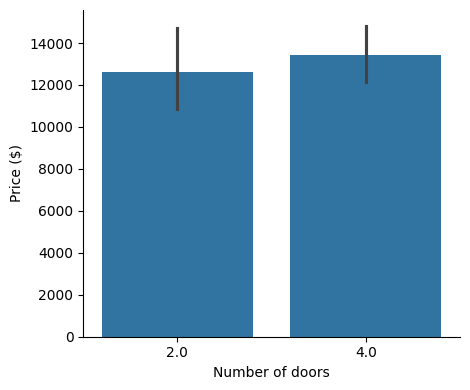

In [57]:
sns.catplot(x="num-of-doors", y="price", data=df, kind="bar", height=4, aspect=1.2)
plt.xlabel("Number of doors")
plt.ylabel("Price ($)")

plt.show()

### Relationships between numerical features and the target

Pairplots to compare numerical variables (and distinguish between diesel and gas cars):

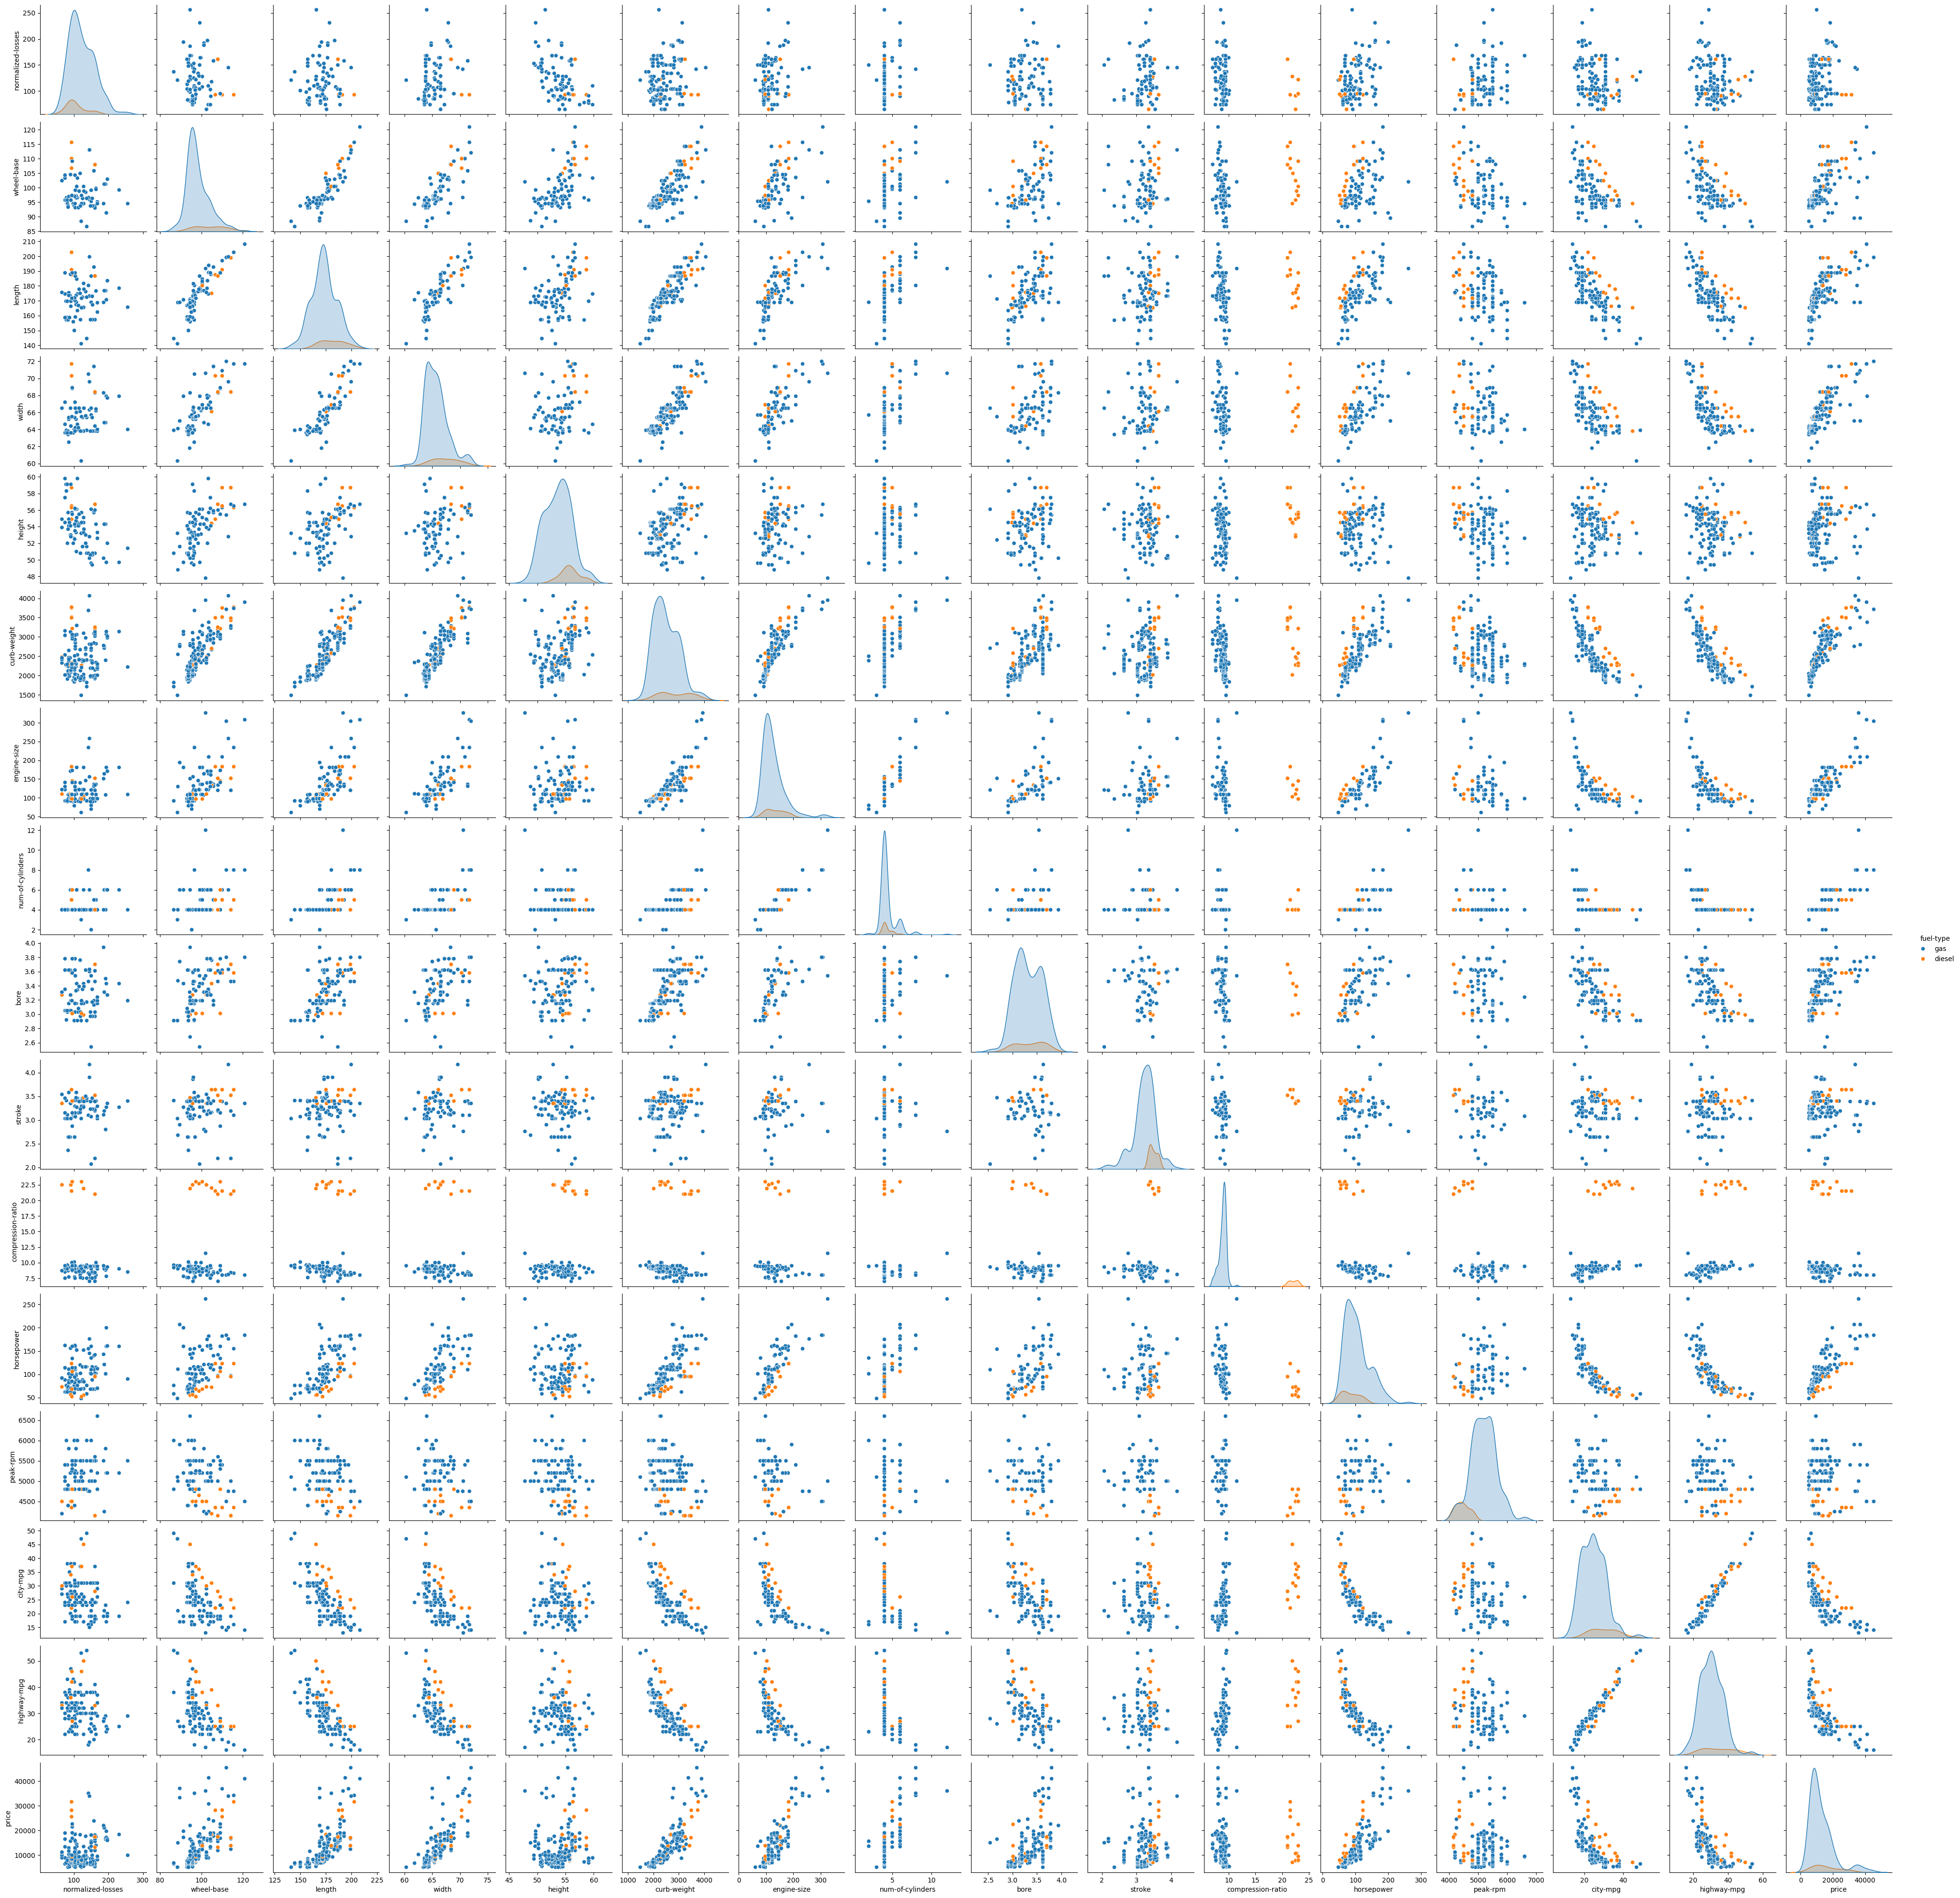

In [58]:
# Numerical variables to analyse
numerical_variables = [
    "normalized-losses",
    "wheel-base",
    "length",
    "width",  #
    "height",  #
    "curb-weight",
    "engine-size",
    "num-of-cylinders",
    "bore",  #
    "stroke",  #
    "compression-ratio",  #
    "horsepower",
    "peak-rpm",  #
    "city-mpg",
    "highway-mpg",
    "price",
]

# Hue variable to consider
hue = ["fuel-type"]

# Plot the pairs of variables
sns.pairplot(df[numerical_variables + hue], hue=hue[0])

plt.show()

As can be seen from these plots:
* Length measures - such as wheelbase, length, width - and weight measures (namely, curb weight) are correlated pair-wise. This is expected, as with the increase of the length so does the wheelbase and width, and the curb weight (as the car will be bigger)
* Engine size is positively correlated with curb weight and horsepower.
* Horsepower is negatively correlated (in a nonlinear way) with city and highway MPG (which, in my opinion, also makes sense, as cars with higher power will consume more than a car with less power with the same amount of fuel).
* Price is positively correlated with horse power and engine size, and negatively correlated with city and highway MPG, in a nonlinear way.

Compute the correlation matrix:

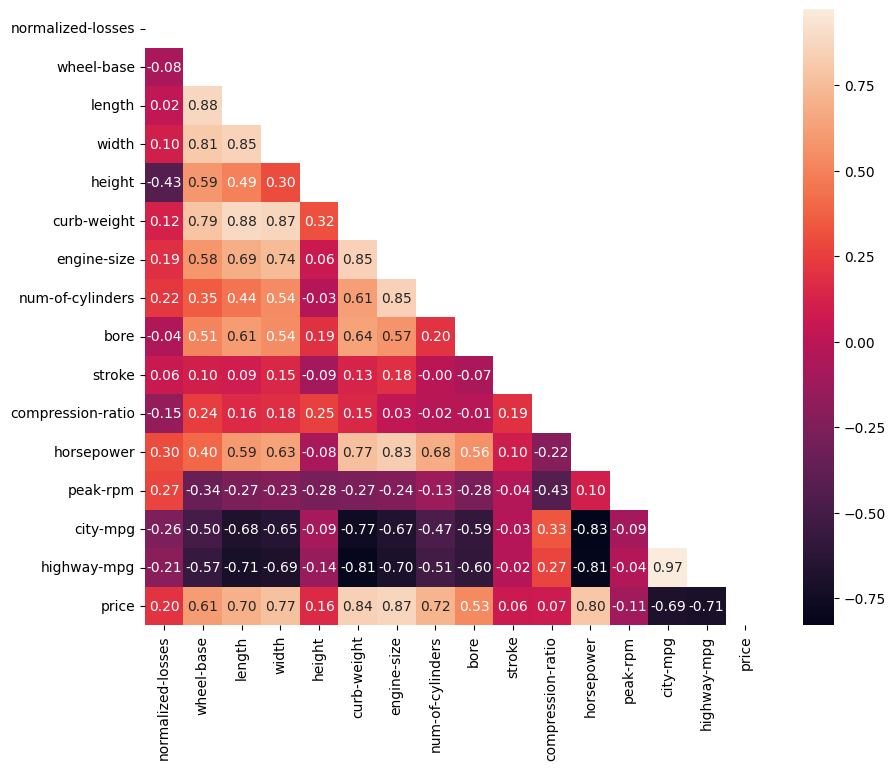

In [59]:
corr = df[numerical_variables].corr()
mask = np.triu(corr)

figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, fmt=".2f", mask=mask)

plt.show()

I will consider strong positive/negative correlation a correlation that is greater, in absolute value, than 0.70.

From the analysis of the matrix, I concluded that:
* Wheel base, length, width and curb-weight are strongly correlated. Given this high value for the correlations and that these are somewhat redundant with each other (as they all concern a form of measure) except curb weight, it makes sense to keep only one, to avoid multicollinearity.
* Horse power is correlated with engine size and curb weight.
* Highway MPG and City MPG are negatively correlated with curb weight and horsepower.
* Highway MPG and city MPG are highly correlated.

In regards to the target variable:
* Price is strongly correlated with width, length, curb weight, engine size, number of cylinders and horse power.
* It is negatively correlated with Highway MGP.

I will also check the importance of the different features quickly by fitting a very basic, non-tuned random forest regressor model:

In [60]:
# Pipeline to engineer Features
pipe = Pipeline(
    [
        # Perform median imputation on the columns that have missing values
        (
            "median_imputation",
            MeanMedianImputer(
                imputation_method="median",
                variables=[
                    "normalized-losses",
                    "bore",
                    "stroke",
                    "horsepower",
                    "peak-rpm",
                ],
            ),
        ),
        
        # Impute the number of doors column
        (
            "categorical_imputation",
            CategoricalImputer(
                imputation_method="frequent",
                variables=["num-of-doors"],
                ignore_format=True,
            ),
        ),
    ]
)

# Create the train dataset and the target column
X = df.drop(columns=["price"])
y = df["price"]

# Transform the training data
X = pipe.fit_transform(X)

# Select only the numerical columns
X = X[[f for f in numerical_variables if f != "price"]]

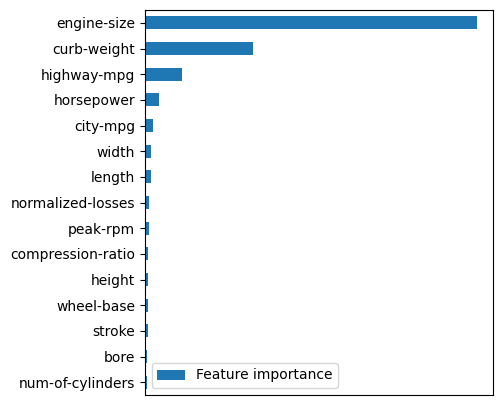

In [61]:
# Build a simple Random Forest regressor to have a quick look at feature importance
regressor = RandomForestRegressor()
regressor.fit(X, y)

# Get the importances
importances = pd.DataFrame(
    regressor.feature_importances_, index=X.columns, columns=["Feature importance"]
)

importances = importances.sort_values(ascending=True, by="Feature importance")

# Plot
importances.plot(kind="barh", figsize=(4.5, 5))

plt.xticks([])
plt.show()

Engine size, curb weight and highway-mpg seem to be strong predictors for the price.

***

## Feature Engineering pipeline

Create the train and test sets:

In [62]:
# Create the train and test sets
X = df.drop(columns=["price"])
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, random_state=0
)

### Baseline model

To get a baseline model, a pipeline with the following steps was be considered:

1. Median imputation of numerical variables. The median is chosen over the mean because of the nature of the distribution of these variables (as most of them have a right-skewed distribution).
2. Mode imputation of categorical variables. For categorical variables, the missing values are filled with the mode value.
3. One-hot encoding of categorical features. Here dummy encoding is considered.
4. Fitting a Linear Regression model.

This model considered **all** features.

In [63]:
pipe = Pipeline(
    [
        # Perform median imputation on the numerical features
        (
            "median_imputation",
            MeanMedianImputer(
                imputation_method="median",
                variables=[
                    "normalized-losses",
                    "bore",
                    "stroke",
                    "horsepower",
                    "peak-rpm",
                ],
            ),
        ),
        
        # Perform imputation on categorical features with the mode
        (
            "categorical_imputation",
            CategoricalImputer(
                imputation_method="frequent",
                variables=["num-of-doors"],
                ignore_format=True,
            ),
        ),

        # Perform one hot encoding of non-numerical features
        (
            "one_hot_encoding",
            OneHotEncoder(
                drop_last=True,
                variables=[
                    "make",
                    "fuel-type",
                    "aspiration",
                    "body-style",
                    "drive-wheels",
                    "engine-location",
                    "engine-type",
                    "fuel-system",
                ],
            ),
        ),

        # Linear Regression
        ("lin_reg", LinearRegression()),
    ]
)

# Fit the pipeline
pipe.fit(X_train, y_train)

# Make predictions on test set
y_test_pred = pipe.predict(X_test)

# Make predictions on train set
y_train_pred = pipe.predict(X_train)

To evaluate model performance, I considered the Root Mean Squared Error (RMSE) as the main metric. It has the advantage that it is in the same scale and has the same units as the target variable.

I also calculated R^2 and MAPE:

In [64]:
# Calculate RMSE, MAPE and R^2
test_rmse = np.round(mean_squared_error(y_test_pred, y_test, squared=False), 2)
train_rmse = np.round(mean_squared_error(y_train_pred, y_train, squared=False), 2)

test_mape = np.round(mean_absolute_percentage_error(y_test_pred, y_test) * 100, 2)
train_mape = np.round(mean_absolute_percentage_error(y_train_pred, y_train) * 100, 2)

test_r2 = np.round(r2_score(y_test_pred, y_test), 2)
train_r2 = np.round(r2_score(y_train_pred, y_train), 2)

# Print results
print(f"RMSE on train set: {train_rmse}\nRMSE on test set: {test_rmse}\n")
print(f"MAPE on train set: {train_mape}\nMAPE on test set: {test_mape}\n")
print(f"R^2 on train set: {train_r2}\nR^2 on test set: {test_r2}")

RMSE on train set: 1475.8
RMSE on test set: 2432.37

MAPE on train set: 9.67
MAPE on test set: 17.28

R^2 on train set: 0.96
R^2 on test set: 0.9


As can be seen, there is a large difference in the scores between the train and test sets. This is an indicator that the baseline model is overfitting the training data, and is overly complex.

### Iteration #1

The first iteration over the baseline used a linear regression model, but focused on a smaller subset of features as to reduce model complexity. 

In addition, rare categories in the "make", "body-style" and "fuel-system" were grouped into an "Other" category. For "make", the threshold below which a category is considered rare was set set to 2.5%, whereas for "body-style" and "fuel-system" it was set to 5%.

In [65]:
features_drop = [
    # Numerical variables
    "stroke",                   # Low correlation with price
    "peak-rpm",                 # Low correlation with price
    "compression-ratio",        # Low correlation with price
    "symboling",                # Low correlation with price
    "width",                    # Moderate correlation with engine size, high correlation with length
    "normalized-losses",        # Many missing values, low correlation with price
    "city-mpg",                 # Strong correlation with Highway MPG
    "curb-weight",              # Strong correlation with Engine size
    "horsepower",               # Strong correlation with Engine size
    "wheel-base",               # Strong correlation with length
    # Categorical variables
    "num-of-doors",             # Similar distribution between groups
    "num-of-cylinders",         # Strong correlation with Engine size
    ]

pipe = Pipeline(
    [
        # Drop columns
        (
            "drop_columns",
            DropFeatures(
                features_to_drop=features_drop
            ),
        ),

        # Perform median imputation on the numerical features
        (
            "median_imputation",
            MeanMedianImputer(
                imputation_method="median",
                variables=[
                    "bore"
                    ],
            ),
        ),

        # Group rare categories of Make into "Other" category
        (
            "rare_label_encoding",
            RareLabelEncoder(
                tol=0.025, n_categories=10, replace_with="Other", variables=["make"]
            ),
        ),

        # Group rare categories of Body style and Fuel system into "Other" category
        (
            "rare_label_encoding_2",
            RareLabelEncoder(
                tol=0.05,
                n_categories=3,
                replace_with="Other",
                variables=[
                    "body-style", 
                    "fuel-system"
                    ],
            ),
        ),

        # Perform one hot encoding of non numerical features
        (
            "one_hot_encoding",
            OneHotEncoder(
                drop_last=True,
                variables=[
                    "make",
                    "fuel-type",
                    "aspiration",
                    "body-style",
                    "drive-wheels",
                    "engine-type",
                    "fuel-system",
                    "engine-location",
                ],
            ),
        ),

        # Linear Regression
        ("lin_reg", LinearRegression()),
    ]
)

# Fit the pipeline
pipe.fit(X_train, y_train)

# Make predictions on test set
y_test_pred = pipe.predict(X_test)

# Make predictions on train set
y_train_pred = pipe.predict(X_train)

Compute the scores:

In [66]:
# Calculate RMSE, MAPE and R^2
test_rmse = np.round(mean_squared_error(y_test_pred, y_test, squared=False), 2)
train_rmse = np.round(mean_squared_error(y_train_pred, y_train, squared=False), 2)

test_mape = np.round(mean_absolute_percentage_error(y_test_pred, y_test) * 100, 2)
train_mape = np.round(mean_absolute_percentage_error(y_train_pred, y_train) * 100, 2)

test_r2 = np.round(r2_score(y_test_pred, y_test), 2)
train_r2 = np.round(r2_score(y_train_pred, y_train), 2)

# Print results
print(f"RMSE on train set: {train_rmse}\nRMSE on test set: {test_rmse}\n")
print(f"MAPE on train set: {train_mape}\nMAPE on test set: {test_mape}\n")
print(f"R^2 on train set: {train_r2}\nR^2 on test set: {test_r2}")

RMSE on train set: 2059.22
RMSE on test set: 2029.79

MAPE on train set: 11.28
MAPE on test set: 12.96

R^2 on train set: 0.93
R^2 on test set: 0.92


Model performance increased substantially, and the large gap in scores between the train and test sets was reduced.

### Iteration #2

The second iteration kept the changes regarding feature selection and grouping, but used Ridge regression instead of Linear Regression. To facilitate the convergence process of the algorithm and obtain reliable results, features were scaled using standard scaling.

The best alpha parameter of Ridge regression - which controls the strength of regularization - was found with grid search and 3-fold cross validation.

In [67]:
pipe_ridge = Pipeline(
    [
        # Drop columns
        (
            "drop_columns",
            DropFeatures(features_to_drop=features_drop),
        ),
        
        # Perform median imputation on the numerical features
        (
            "median_imputation",
            MeanMedianImputer(
                imputation_method="median",
                variables=["bore"],
            ),
        ),

        # Group rare categories of Make into "Other" category
        (
            "rare_label_encoding",
            RareLabelEncoder(
                tol=0.025, n_categories=10, replace_with="Other", variables=["make"]
            ),
        ),

        # Group rare categories of Body style and Fuel system into "Other" category
        (
            "rare_label_encoding_2",
            RareLabelEncoder(
                tol=0.05,
                n_categories=3,
                replace_with="Other",
                variables=["body-style", "fuel-system"],
            ),
        ),

        # Perform one hot encoding of non numerical features
        (
            "one_hot_encoding",
            OneHotEncoder(
                drop_last=True,
                variables=[
                    "make",
                    "fuel-type",
                    "aspiration",
                    "body-style",
                    "drive-wheels",
                    "engine-type",
                    "fuel-system",
                    "engine-location",
                ],
            ),
        ),

        # Scale the data
        ('standard_scaler', StandardScaler()),

        # Ridge Regression model
        ("ridge", Ridge()),
    ]
)


# Define the parameter grid for the regression algorithm
param_grid = {
    "ridge__alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
}

# Find the best parameter using a grid search
grid_search = GridSearchCV(
    pipe_ridge, param_grid, cv=3, scoring="neg_mean_squared_error"
)

grid_search.fit(X_train, y_train)

# Get predictions with the best estimator
y_test_pred = grid_search.predict(X_test)
y_train_pred = grid_search.predict(X_train)

In [68]:
# Calculate RMSE, MAPE and R^2
test_rmse = np.round(mean_squared_error(y_test_pred, y_test, squared=False), 2)
train_rmse = np.round(mean_squared_error(y_train_pred, y_train, squared=False), 2)

test_mape = np.round(mean_absolute_percentage_error(y_test_pred, y_test) * 100, 2)
train_mape = np.round(mean_absolute_percentage_error(y_train_pred, y_train) * 100, 2)

test_r2 = np.round(r2_score(y_test_pred, y_test), 2)
train_r2 = np.round(r2_score(y_train_pred, y_train), 2)

# Print results
print(f"RMSE on train set: {train_rmse}\nRMSE on test set: {test_rmse}\n")
print(f"MAPE on train set: {train_mape}\nMAPE on test set: {test_mape}\n")
print(f"R^2 on train set: {train_r2}\nR^2 on test set: {test_r2}")

RMSE on train set: 2059.41
RMSE on test set: 2027.11

MAPE on train set: 11.28
MAPE on test set: 12.97

R^2 on train set: 0.93
R^2 on test set: 0.92


Performance on the test set increased slightly, but is still comparable to the previous approach.

Check which alpha value gave the best performance in the validation folds:

In [69]:
grid_search.best_params_

{'ridge__alpha': 0.1}

Check the residuals:

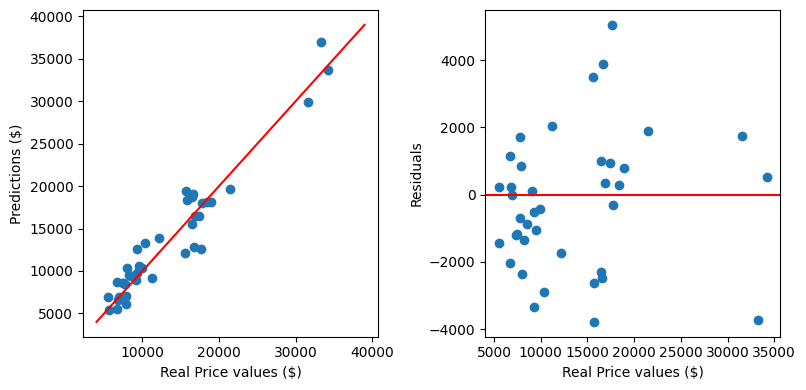

In [70]:
residuals = y_test - y_test_pred

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(8, 4),
)

axs[0].scatter(y_test, y_test_pred)
axs[1].scatter(y_test, residuals)

axs[0].plot(np.arange(4000, 40000, 1000), np.arange(4000, 40000, 1000), color="r")
axs[1].axhline(y=0, color="r")

axs[0].set_xlabel("Real Price values ($)")
axs[1].set_xlabel("Real Price values ($)")

axs[0].set_ylabel("Predictions ($)")
axs[1].set_ylabel("Residuals")

fig.tight_layout()
plt.show()

Save the model:

In [71]:
pickle.dump(grid_search, open("model/pipeline.pkl", "wb"))

***

## Annex

Additional plots for the PowerPoint presentation.

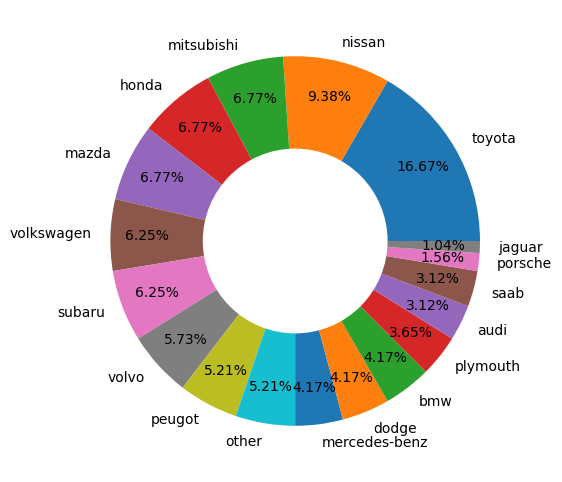

In [72]:
# Pie chart for the PPT
df["make"].replace(
    {
        "chevrolet": "other",
        "alfa-romero": "other",
        "isuzu": "other",
        "renault": "other",
        "mercury": "other",
    }
).value_counts().plot(
    kind="pie",
    figsize=(11, 6),
    autopct="%1.2f%%",
    pctdistance=0.80,
)

hole = plt.Circle((0, 0), 0.5, facecolor="white")
plt.gcf().gca().add_artist(hole)

plt.ylabel(None)
plt.xticks(rotation=45)

plt.show()

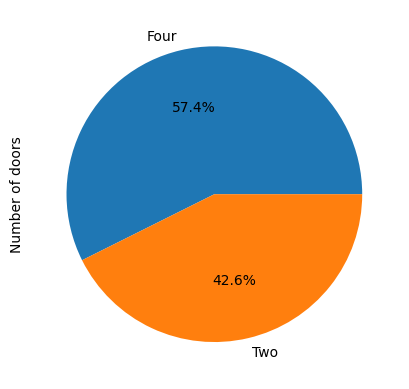

In [73]:
# Pie chart for the PPT
df["num-of-doors"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    labels=["Four", "Two"],
)

plt.ylabel("Number of doors")

plt.show()

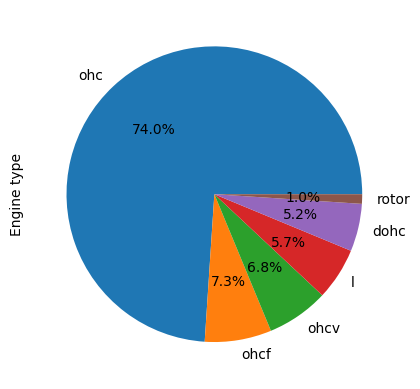

In [74]:
# Pie chart for the PPT
df["engine-type"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    #labels=["Front wheels drive", "Rear Wheels drive", "4X4"],
)

plt.ylabel("Engine type")

plt.show()

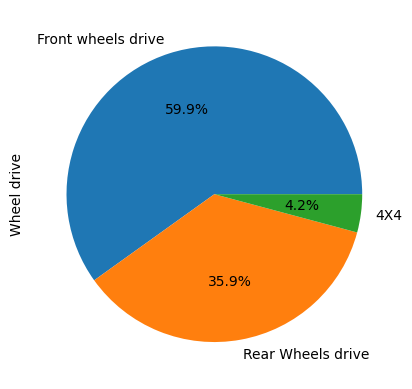

In [75]:
# Pie chart for the PPT
df["drive-wheels"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    labels=["Front wheels drive", "Rear Wheels drive", "4X4"],
)

plt.ylabel("Wheel drive")

plt.show()

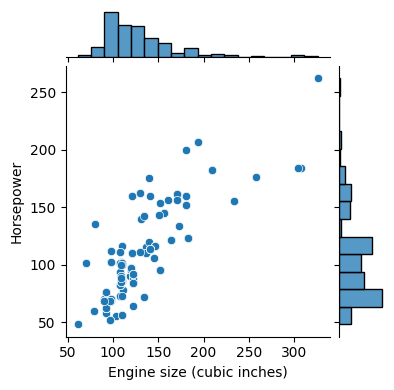

In [76]:
# Joint plot for the PPT
sns.jointplot(x="engine-size", y="horsepower", data=df, height=4, ratio=5, color='#1f77b4')

plt.xlabel("Engine size (cubic inches)")
plt.ylabel("Horsepower")

plt.show()